In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from scipy.special import erf
import pandas as pd

from axion_functions import *

In [2]:
cast_df = pd.read_table("..\\cast.txt")
cast_df.columns = ["m_a ev", "g gev"]
cast_df

,m_a ev,g gev
0,0.000114,6.631623e-11
1,0.000124,6.632154e-11
2,0.000135,6.632685e-11
3,0.000146,6.633216e-11
4,0.000159,6.633746e-11
...,...,...
333,1.152127,4.759319e-10
334,1.156156,5.007951e-10
335,1.159620,3.625133e-10
336,1.166579,3.981088e-10


In [3]:
cast_M_df = pd.read_table("..\\cast_highm.txt")
cast_M_df.columns = ["m_a ev", "g gev"]
cast_M_df

,m_a ev,g gev
0,0.003622,8.829700e-11
1,0.004596,8.829700e-11
2,0.005890,8.829700e-11
3,0.007840,8.829700e-11
4,0.009950,8.988100e-11
...,...,...
112,1.031100,2.589000e-09
113,1.061800,3.727600e-09
114,1.093100,4.573300e-09
115,1.169000,5.610900e-09


(0.00012, 10000.0)

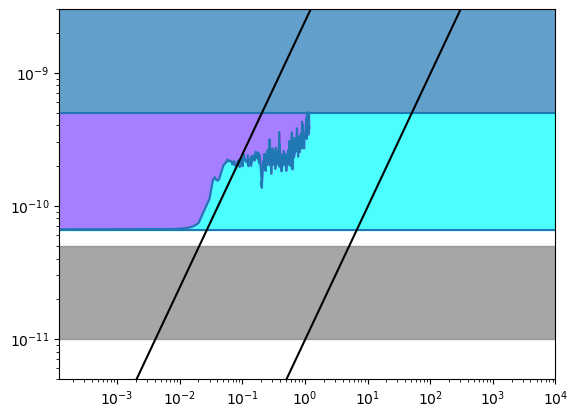

In [43]:
fig,ax = plt.subplots()
mass_axis = np.logspace(-4, 4)
#ax.plot(cast_M_df["m_a ev"], cast_M_df["g gev"])
ax.plot(cast_df["m_a ev"], cast_df["g gev"])

ax.hlines(5e-10, 1e-4, 1e4)
xenon = ax.fill_between((1e-4, 1e4), 5e-10, 3e-9, alpha=0.7)
hb_cut = ax.fill_between((1e-4, 1e4), 0.66e-10, 5e-10, color="cyan", alpha=0.7)
ax.hlines(0.66e-10, 1e-4, 1e4)

cast = ax.fill_between(np.array(cast_df["m_a ev"]), 
                 np.array(cast_df["g gev"]), 5e-10, color="magenta", alpha=0.5)

hb_hint = hb_cut = ax.fill_between((1e-4, 1e4), 0.1e-10, 0.5e-10, color="grey", alpha=0.7)

ax.plot(mass_axis, g_ag(mass_axis, en=44/3), color="black")
ax.plot(mass_axis, g_ag(mass_axis, en=2)   , color="black")
#ax.plot(mass_axis, g_ag(mass_axis, en=25/3)   , color="black")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(5e-12, 3e-9)
ax.set_xlim(1.2e-4, 1e4)

In [72]:
#Define constants
a = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy

# Define unknown constants
#g_ag = 2e-10 #Axion-photon coupling (Primakoff process), in GeV^(-1).
#Upper bound on g_ag of 2.7e-10 from the Sun, see Di Luzio's review
#lmda = (g_ag/(1e-8))**4
phi_0 = 5.95e14 #in cm^(-2) s^(-1)
E_0    = 1.103 #in keV

#Crystal Geometry
diam = 110*unit.mm
hgt = 250*unit.mm 
#vol = ((np.pi*(diam/2)**2*hgt).to(unit.AA**3)).value 
mass = 50*unit.kg
vol = ((mass/(3.67*unit.g*(unit.cm)**(-3))).to(unit.AA**3)).value #Crystal volume, in AA^3
#Make volume make the mass like 7kg
vol_cell = 67.71 #In AA^3, from Dent paper

s_in_y = 365.25*24*60*60 #Number of seconds in a year

In [45]:
k=np.array([1,0,0])

g_ag = 2.8e-11

hkl = make_hkl_s()

g_arr = (2*np.pi/a)*hkl #G vectors, in AA^(-1)

mod2_g = mod2(g_arr) #Magnitude square of G vectors, 
FAq = FA_qv2(mod2_g)

ginv_array = 1/mod2_g

ginv_replicant = np.stack((ginv_array, ginv_array,ginv_array), axis=1)

ghat = g_arr*np.sqrt(ginv_replicant) # Correct

gk = np.abs(gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k)))) #correct

sin2 = 4*gk**2*(1-gk**2) 

E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV 

#new_terms = (E_arr/(hbar_kevs*c_aas))**2*ginv_array**2

#summand = ((FAq)**2)*((E_arr/(hbar_kevs*c_aas))**2*ginv_array**2)*sin2*4 #Use *4 if implementing s, *64 for double
#summand = ((FAq)**2)*(ginv_array)*sin2*4 #Use *4 if implementing s, *64 for double

#The infinities here are fine; they go to zero in the W function

#W = w_func(E_arr, E1=1, E2=20, dVector=True, Delta = make_delta(E_arr)) #Delta from Simulation of BG report

W = w_func(E_arr, E1=1, E2=50, dVector=False, Delta = 1) #Delta from Simulation of BG report

dphi_de = make_dpde(E_arr, coupling=g_ag)
final_summand = W*dphi_de*1e-16*((FAq)**2)*((E_arr)**2*ginv_array**2)*sin2*4 #1e-16 to cancel angstroms and cm squared

nt_constant = np.pi*(4*np.pi/137)*(g_ag*1e-6)**2*vol/(vol_cell**2) #in keV
#Conversion factor of angstroms to cm missing somewhere
#Absorption also looks like it's a huge deal (order -9 or so)
final_dndt = nt_constant*np.sum(np.nan_to_num(final_summand)) #in s^(-1), 1e-16 converts angstroms and cm


C:\Users\taase\AppData\Local\Temp\ipykernel_19988\3550232301.py:22: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV
c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Code\axion_functions.py:123: RuntimeWarning: overflow encountered in exp
  dpdt_list.append(np.sqrt(lmda)*(phi_0)/(E_0) * (E/E_0)**3/(np.exp(E/E_0)-1))
C:\Users\taase\AppData\Local\Temp\ipykernel_19988\3550232301.py:36: RuntimeWarning: invalid value encountered in multiply
  final_summand = W*dphi_de*1e-16*((FAq)**2)*((E_arr)**2*ginv_array**2)*sin2*4 #1e-16 to cancel angstroms and cm squared


In [73]:
coupling = 1.25e-10

m_a = 0.01

In [74]:


hkl = np.array(make_hkl_double(max_h = 5, 
                               max_k = 5,
                               max_l = 5))
g_ag = coupling
g_arr = (2*np.pi/a)*hkl #G vectors, in AA^(-1)
mod2_g = mod2(g_arr) #Magnitude square of G vectors, 
FAq_Na = FA_qv2(mod2_g, Z=11)
FAq_I  = FA_qv2(mod2_g, Z=53)
ginv_array = 1/mod2_g
ginv_replicant = np.stack((ginv_array, ginv_array,ginv_array), axis=1)
ghat = g_arr*np.sqrt(ginv_replicant) # Correct
gk = np.abs(gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k)))) #correct


sin2 = 4*gk**2*(1-gk**2) 
summand = ((FAq_Na+FAq_I)**2)*ginv_array*sin2*64 #*4 from S, *4 from form factor F

E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV 
#The infinities here are fine; they go to zero in the W function
#W = w_func(E_arr, E1=1, E2=20, dVector=True, Delta = make_delta(E_arr)) #Delta from Simulation of BG report

W = w_func(E_arr, E1=1, E2=50, dVector=False, Delta = 1) #Delta from Simulation of BG report

dphi_de = primakoff_flux(E_arr, coupling=g_ag, m_a = m_a) + coalescence_flux(E_arr, coupling=g_ag, m_a = m_a)
final_summand = W*dphi_de*1e-16*summand #1e-16 to cancel angstroms and cm squared
nt_constant = np.pi*(g_ag*1e-6)**2*(hbar_kevs*c_aas)**3*vol/(vol_cell**2) #in keV
#Conversion factor of angstroms to cm missing somewhere
#Absorption also looks like it's a huge deal (order -9 or so)
final_dndt = nt_constant*np.sum(final_summand) #in s^(-1), 1e-16 converts angstroms and cm

C:\Users\taase\AppData\Local\Temp\ipykernel_19988\2351965660.py:18: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV


In [84]:
final_summand

array([3.57624688e-03, 3.11387127e-04, 3.57624688e-03, 0.00000000e+00,
       2.46301064e-03, 3.11387127e-04, 2.46301064e-03, 0.00000000e+00,
       3.57624688e-03, 0.00000000e+00, 1.45342410e-07, 0.00000000e+00,
       3.57624688e-03, 2.81852109e-03, 1.45342410e-07, 2.81852109e-03,
       2.46301064e-03, 3.11387127e-04, 1.45342410e-07, 0.00000000e+00,
       1.45342410e-07, 0.00000000e+00, 1.45342410e-07, 0.00000000e+00,
       1.45342410e-07, 3.11387127e-04])

In [78]:
E_arr

array([ 5.60000896, 11.20001793,  5.60000896,  3.73333931,  6.8444554 ,
       11.20001793,  6.8444554 ,  7.46667862,  5.60000896,         inf,
       20.5333662 ,         inf,  5.60000896,  7.46667862, 20.5333662 ,
        7.46667862,  6.8444554 , 11.20001793, 20.5333662 ,         inf,
       20.5333662 ,         inf, 20.5333662 ,         inf, 20.5333662 ,
       11.20001793])

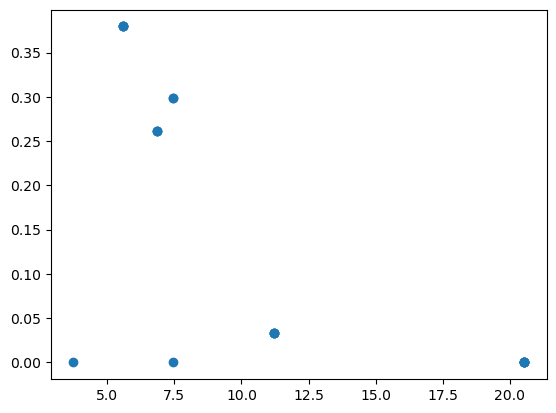

In [83]:
plt.scatter(E_arr, nt_constant*final_summand*s_in_y*3)

In [76]:
final_dndt*s_in_y*3

3.0323324001050587

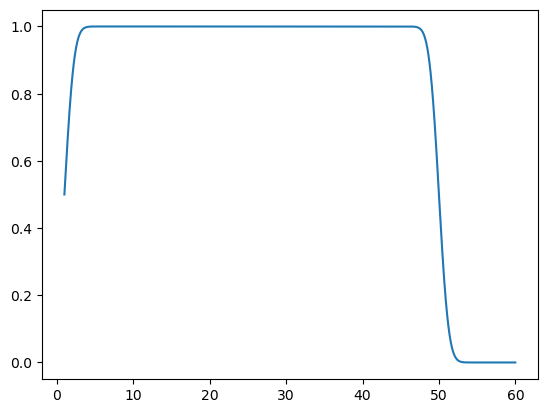

In [88]:
E_arr = np.arange(1, 60, 0.01)
plt.plot(E_arr, w_func(E_arr, E1=1, E2=50, dVector=True, Delta = make_delta(E_arr)))

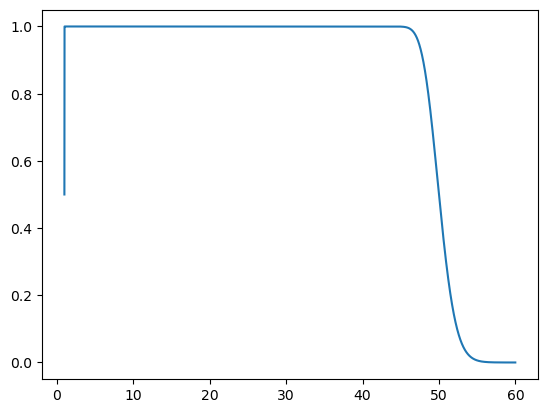

In [89]:
plt.plot(E_arr, w_func(E_arr, E1=1, E2=50, dVector=True, Delta = make_delta(E_arr)))

In [3]:
mass

<Quantity 5.23157644 kg>

In [3]:
g_ap = 1e-8*(u.GeV)**(-1)
vcell = 67.71*u.AA**3
sin2 = 0.9250625464312866

E1 = 1*u.keV 
E2 = 6*u.keV

Ea = np.arange(1.01,5.59,0.01)*u.keV #NOOOOOOOO

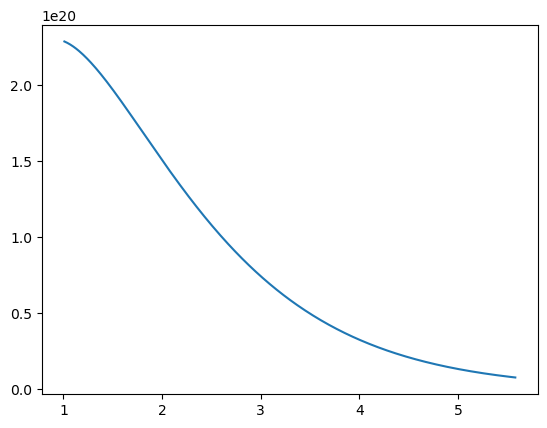

In [4]:
A=0.9*u.keV 
phi_0 = A*(2.3e20*(u.keV*u.yr*u.m**2)**(-1))*np.e

dpdt = (phi_0/A)*(Ea/A)*np.exp(-Ea/A)
plt.plot(Ea, dpdt)

In [5]:
(dpdt).to((u.keV*u.s*u.m**2)**(-1))

<Quantity [7.23806196e+12, 7.22895632e+12, 7.21916817e+12, 7.20871373e+12,
           7.19760891e+12, 7.18586935e+12, 7.17351045e+12, 7.16054731e+12,
           7.14699481e+12, 7.13286755e+12, 7.11817989e+12, 7.10294593e+12,
           7.08717955e+12, 7.07089436e+12, 7.05410376e+12, 7.03682091e+12,
           7.01905874e+12, 7.00082994e+12, 6.98214700e+12, 6.96302217e+12,
           6.94346752e+12, 6.92349486e+12, 6.90311583e+12, 6.88234185e+12,
           6.86118412e+12, 6.83965368e+12, 6.81776132e+12, 6.79551770e+12,
           6.77293323e+12, 6.75001817e+12, 6.72678259e+12, 6.70323635e+12,
           6.67938917e+12, 6.65525057e+12, 6.63082990e+12, 6.60613634e+12,
           6.58117891e+12, 6.55596645e+12, 6.53050764e+12, 6.50481101e+12,
           6.47888492e+12, 6.45273757e+12, 6.42637704e+12, 6.39981120e+12,
           6.37304784e+12, 6.34609454e+12, 6.31895878e+12, 6.29164788e+12,
           6.26416902e+12, 6.23652926e+12, 6.20873549e+12, 6.18079450e+12,
           6.15271294e+12

In [6]:
res = 0.132*Ea
#res = 1*u.keV
w_func = 0.5*(erf((Ea-E1)/(np.sqrt(2)*res)) - erf((Ea-E2)/(np.sqrt(2)*res)))
w_func

<Quantity [0.52989563, 0.55904337, 0.58731874, 0.61461785, 0.64085696,
           0.6659716 , 0.68991531, 0.71265823, 0.7341855 , 0.75449561,
           0.77359866, 0.79151475, 0.80827231, 0.82390665, 0.83845852,
           0.85197282, 0.8644975 , 0.87608251, 0.88677894, 0.89663824,
           0.90571159, 0.91404938, 0.92170079, 0.9287134 , 0.93513298,
           0.94100328, 0.94636589, 0.95126017, 0.9557232 , 0.95978978,
           0.96349247, 0.96686162, 0.96992546, 0.97271015, 0.9752399 ,
           0.97753705, 0.97962218, 0.98151423, 0.98323055, 0.98478708,
           0.98619839, 0.98747779, 0.98863746, 0.98968847, 0.99064093,
           0.99150404, 0.99228617, 0.99299491, 0.99363718, 0.99421924,
           0.99474678, 0.99522494, 0.99565841, 0.99605141, 0.99640778,
           0.99673099, 0.99702418, 0.9972902 , 0.99753161, 0.99775074,
           0.9979497 , 0.9981304 , 0.99829454, 0.9984437 , 0.99857928,
           0.99870254, 0.99881466, 0.99891665, 0.99900948, 0.99909399,
      

In [7]:
print(((Ea-E1)/(np.sqrt(2)*res))[:5].si)
print(((Ea-E2)/(np.sqrt(2)*res))[:5].si)

[0.05303831 0.10503666 0.15602533 0.20603344 0.25508903]
[-26.4661179  -26.15412782 -25.84819581 -25.54814711 -25.25381361]


In [8]:
G0 = 9.6
dndt = np.pi*g_ap**2*(c.hbar*c.c)**3*vol/(vcell)**2 * G0*dpdt*sin2*w_func
dndt.si

<Quantity [2.55637835e+10, 2.69360309e+10, 2.82600882e+10, 2.95308156e+10,
           3.07441047e+10, 3.18968301e+10, 3.29867870e+10, 3.40126148e+10,
           3.49737152e+10, 3.58701650e+10, 3.67026284e+10, 3.74722713e+10,
           3.81806779e+10, 3.88297735e+10, 3.94217520e+10, 3.99590114e+10,
           4.04440945e+10, 4.08796377e+10, 4.12683264e+10, 4.16128567e+10,
           4.19159033e+10, 4.21800929e+10, 4.24079830e+10, 4.26020452e+10,
           4.27646523e+10, 4.28980694e+10, 4.30044473e+10, 4.30858196e+10,
           4.31441005e+10, 4.31810859e+10, 4.31984548e+10, 4.31977724e+10,
           4.31804939e+10, 4.31479689e+10, 4.31014465e+10, 4.30420806e+10,
           4.29709353e+10, 4.28889900e+10, 4.27971457e+10, 4.26962295e+10,
           4.25870005e+10, 4.24701543e+10, 4.23463283e+10, 4.22161057e+10,
           4.20800205e+10, 4.19385608e+10, 4.17921734e+10, 4.16412665e+10,
           4.14862136e+10, 4.13273564e+10, 4.11650072e+10, 4.09994521e+10,
           4.08309529e+10

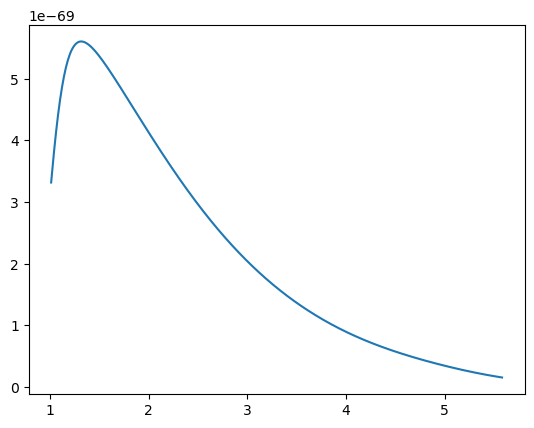

In [9]:
plt.plot(Ea,dndt)

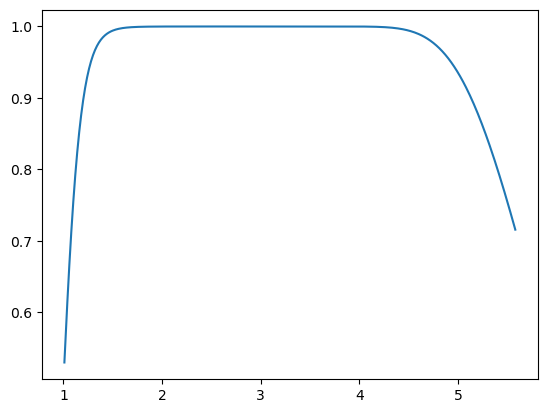

In [10]:
plt.plot(Ea,w_func)

In [11]:
(1*u.s/u.yr).si

<Quantity 3.16880878e-08>

In [12]:
g_app = g_ap
m = 5
E = np.arange(m,16,0.01)
p = np.sqrt(E**2 - m**2)
phi_mass = (1.68e9*(u.cm**2*u.s*u.keV)**(-1))*(g_app*u.GeV/(1e-10))**2*m**4*p*(10/(0.2+E**2)+1+0.0006*E**3)*np.exp(-E)


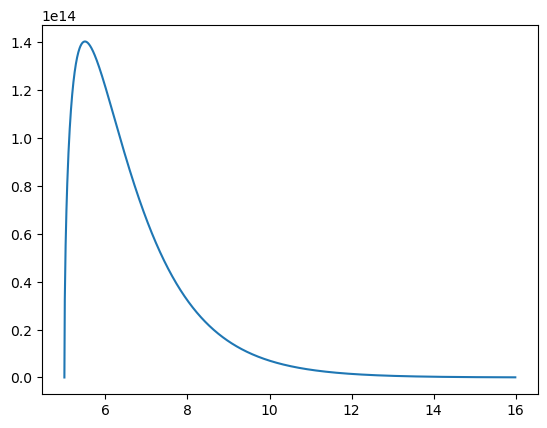

In [13]:
plt.plot(E, phi_mass)

In [14]:
phi_mass

<Quantity [0.00000000e+00, 3.25924436e+13, 4.56224357e+13, ...,
           6.43220689e+10, 6.38094124e+10, 6.33008070e+10] 1 / (cm2 keV s)>

In [80]:
def make_hkl(max_h=5,max_k=5,max_l=5):
    output_list = []
    for h in range(max_h+1):
        for k in range(max_k+1):
            if k%2 == h%2:
                for l in range(max_l+1):
                    if l%2 == h%2:
                        output_list.append((h,k,l))
    return output_list[1:]

def mod2(tuple, ax=0):
    return np.sum(np.square(tuple), axis=ax)


In [112]:
hkl = np.array(make_hkl()) #Indexed to [52,2], removing trivial case
ginv_array = (1/np.apply_over_axes(mod2, hkl, 1))
np.sum((4/np.pi**2)*ginv_array*sin2)


39.54434610904615

In [116]:
ghat = hkl*np.sqrt(ginv_array)
sin2 = 4*ghat[:,0]**2*(1-ghat[:,0]**2) #assume k = [1,0,0]; we can like integrate over 1 day maybe

summand = (4/np.pi**2)*ginv_array[:,0]*sin2
np.sum(summand)

0.6105213612652185